In [179]:
import numpy as np
import pandas as pd
import ast 
import matplotlib.pyplot as plt
import seaborn as sns

In [180]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [181]:
train = pd.read_csv('pdd_features.csv')
train = train.drop(columns=["filename"])
train.sample(5)

,head_movement,feature_lengths,flicker,blink,lip_movement_variance,ssim,psnr,pulse,fake
21,"[1.1471244096755981, 1.1471244096755981, -0.72...","[45.0, 5.0, 5.0, 50.0, 50.0, 45.0, 45.0]","[-0.7609813213348389, 0.5508744716644287, -0.7...","[5.0, 1.0, 4.0, 0.0, 2.0]","[0.4536091983318329, 1.1025309562683105, 0.637...","[0.8272214531898499, -1.071358561515808, 0.833...","[0.54686439037323, -1.0026414394378662, 0.5808...","[134.1508026123047, 134.1508026123047, 134.150...",0
23,"[-0.48002779483795166, -0.7881585359573364, 0....","[45.0, 5.0, 5.0, 50.0, 50.0, 45.0, 45.0]","[-0.860231339931488, 0.6818062663078308, -0.81...","[0.0, 0.0, 1.0, 0.0, 0.0]","[0.753778338432312, 0.8045976758003235, 0.5725...","[1.01362943649292, -0.8952516317367554, 0.9874...","[0.8165046572685242, -0.8271097540855408, 0.73...","[31.855600357055664, 31.855600357055664, 31.78...",0
6,"[0.5599150657653809, 0.5665221810340881, -1.99...","[45.0, 5.0, 5.0, 50.0, 50.0, 45.0, 45.0]","[-0.8409959673881531, 1.9394997358322144, -0.8...","[0.0, 0.0, 0.0, 0.0, 7.0]","[0.9494253396987915, 0.7149065732955933, 0.937...","[0.9457259178161621, -1.499052882194519, 0.963...","[1.0107682943344116, -1.1261746883392334, 0.96...","[111.88680267333984, 111.88680267333984, 111.8...",1
16,"[1.0122313499450684, 1.9643055200576782, 0.162...","[45.0, 5.0, 5.0, 50.0, 50.0, 45.0, 45.0]","[-0.8335750102996826, 0.7445854544639587, -0.8...","[2.0, 5.0, 6.0, 3.0, 0.0]","[0.7407407164573669, 1.1111111640930176, 0.768...","[0.8504745960235596, -0.9224911332130432, 0.89...","[0.7391156554222107, -1.0195008516311646, 0.86...","[98.82720184326172, 99.26959991455078, 99.1656...",1
27,"[1.3814456462860107, 1.3787037134170532, 0.877...","[45.0, 5.0, 5.0, 50.0, 50.0, 45.0, 45.0]","[-0.7324457168579102, 0.38080352544784546, -0....","[0.0, 1.0, 0.0, 0.0, 0.0]","[0.8888888955116272, 0.7881104350090027, 1.010...","[0.9769716262817383, -0.6641132831573486, 0.17...","[0.820024311542511, -1.145582675933838, 0.8074...","[73.98999786376953, 73.98999786376953, 73.9899...",0


In [182]:
test = pd.read_csv('eval_features.csv')
test = test.drop(columns=["filename"])
test.sample(5)

,head_movement,feature_lengths,flicker,blink,lip_movement_variance,ssim,psnr,pulse,fake
45,"[1.0059313774108887, 1.076404333114624, 1.3599...","[45.0, 5.0, 5.0, 50.0, 50.0, 45.0, 45.0]","[-0.823874294757843, -0.07620193064212799, -0....","[0.0, 0.0, 0.0, 0.0, 0.0]","[1.1318329572677612, 0.0, 0.0, 0.0, 0.0]","[1.0650511980056763, -0.21454061567783356, 0.9...","[0.9398735165596008, -0.5915416479110718, 0.57...","[-0.7114042639732361, -0.7563942670822144, -0....",0
20,"[-1.4955594539642334, -1.4955594539642334, 0.7...","[45.0, 5.0, 5.0, 50.0, 50.0, 45.0, 45.0]","[-0.6257169842720032, 0.06792561709880829, -0....","[1.0, 1.0, 4.0, 0.0, 0.0]","[0.9858757853507996, 1.0108314752578735, 1.062...","[0.628549337387085, -0.09974837303161621, 0.71...","[0.8321359753608704, -0.6424777507781982, 1.79...","[0.1425800770521164, 0.08506369590759277, 0.96...",0
46,"[1.9139891862869263, 1.889148473739624, -0.940...","[45.0, 5.0, 5.0, 50.0, 50.0, 45.0, 45.0]","[-0.7574509978294373, 0.53578782081604, -0.761...","[4.0, 4.0, 8.0, 12.0, 4.0]","[0.7511157393455505, 0.6700252294540405, 0.630...","[0.8263994455337524, -0.757413387298584, 0.830...","[0.8224049210548401, -1.0105839967727661, 0.85...","[-0.5569972991943359, -0.5569972991943359, -0....",0
27,"[-1.996712565422058, 0.5605862736701965, 0.530...","[45.0, 5.0, 5.0, 50.0, 50.0, 45.0, 45.0]","[-0.815743625164032, 1.002050757408142, -0.814...","[0.0, 0.0, 0.0, 0.0, 0.0]","[1.0663822889328003, 0.6039118766784668, 0.855...","[0.7862766981124878, -0.4089970588684082, 0.81...","[0.8917901515960693, -0.977398157119751, 0.883...","[-0.9948979020118713, -0.9948979020118713, -1....",0
38,"[-1.9722247123718262, -2.0224828720092773, 0.5...","[45.0, 5.0, 5.0, 50.0, 50.0, 45.0, 45.0]","[-0.8066376447677612, 1.4396544694900513, -0.7...","[10.0, 15.0, 10.0, 6.0, 14.0]","[0.9402532577514648, 0.5555555820465088, 0.634...","[0.8291622400283813, -1.2084213495254517, 0.73...","[0.8159055709838867, -1.2686259746551514, 0.35...","[1.7677019834518433, 1.7527010440826416, 0.197...",0


In [183]:
# Option 1: Concatenate all features (flatten nested lists)

def safe_eval_np_float64(x):
    if isinstance(x, str):
        return eval(x, {"np": np})
    return x

for col in train.columns:
    if col != "fake":
        train[col] = train[col].apply(safe_eval_np_float64)
    
for col in test.columns:
    if col != "fake":
        test[col] = test[col].apply(ast.literal_eval)

In [184]:
# Flatten each row of lists into a single feature vector
X_train = np.array([np.concatenate(row.values) for _, row in train.drop(columns=["fake"]).iterrows()])
y_train = train["fake"].values

X_test = np.array([np.concatenate(row.values) for _, row in test.drop(columns=["fake"]).iterrows()])
y_test = test["fake"].values

In [185]:
# #option 2: summarize each list with aggregate features (mean, std, etc.)
# for col in df.columns:
#     if col != "fake":
#         df[col] = df[col].apply(ast.literal_eval)

# agg_df = df.copy()
# for col in df.columns:
#     if col != "fake":
#         agg_df[f"{col}_mean"] = df[col].apply(np.mean)
#         agg_df[f"{col}_std"] = df[col].apply(np.std)
#         agg_df[f"{col}_max"] = df[col].apply(np.max)
#         agg_df[f"{col}_min"] = df[col].apply(np.min)

# # drop the original list-based columns
# agg_df = agg_df.drop(columns=[col for col in df.columns if col != "fake"])

# # final X and y
# X = agg_df.drop(columns=["fake"]).values
# y = agg_df["fake"].values

In [186]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.7, random_state=27)

In [187]:
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Function to run model

In [188]:
def evaluate_model(model, model_name):
    print(f"Training {model_name}...")
    
    # Fit model
    model.fit(X_train, y_train)
    
    # Predict on test data
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC (probabilities for positive class)
    
    target_names = ["Authentic", "Deepfake"]
    
    # Calculate accuracy, AUC, and confusion matrix
    acc = metrics.accuracy_score(y_test, y_pred)
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    auc = round(metrics.auc(fpr, tpr), 2)
    cm = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, target_names=target_names)
    
    # Print the classification report for the model
    print(f"Classification Report for {model_name}:\n{class_report}\n")
    print(f"Accuracy for {model_name}: {acc:.4f}")
    print(f"AUC for {model_name}: {auc:.4f}\n")

    # Plot confusion matrix for the model
    fig, ax = plt.subplots(figsize=(5, 4))
    sns.heatmap(cm, annot=True, cmap='Blues_r', fmt='g', xticklabels=target_names, yticklabels=target_names, ax=ax)
    ax.set_xlabel("Predicted Values")
    ax.set_ylabel("Actual Values")
    ax.set_title(f"Confusion Matrix for {model_name}")
    plt.show()

    return round(acc, 4), round(auc, 4), cm

Logistic Regression

Training Logistic Regression...
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

   Authentic       0.69      0.30      0.42        30
    Deepfake       0.43      0.80      0.56        20

    accuracy                           0.50        50
   macro avg       0.56      0.55      0.49        50
weighted avg       0.59      0.50      0.48        50


Accuracy for Logistic Regression: 0.5000
AUC for Logistic Regression: 0.5600



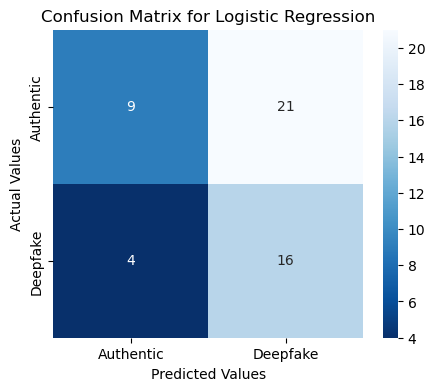

In [189]:
log_reg = LogisticRegression(solver='liblinear')
log_reg_acc, log_reg_auc, log_reg_cm = evaluate_model(log_reg, "Logistic Regression")

Decision Tree

Training Decision Tree...
Classification Report for Decision Tree:
              precision    recall  f1-score   support

   Authentic       0.57      0.53      0.55        30
    Deepfake       0.36      0.40      0.38        20

    accuracy                           0.48        50
   macro avg       0.47      0.47      0.47        50
weighted avg       0.49      0.48      0.48        50


Accuracy for Decision Tree: 0.4800
AUC for Decision Tree: 0.4700



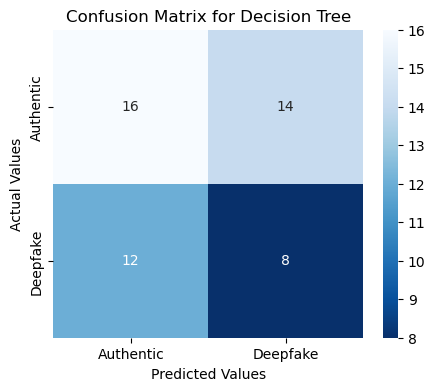

In [190]:
dt = DecisionTreeClassifier()
dt_acc, dt_auc, dt_cm = evaluate_model(dt, "Decision Tree")

Naive Bayes


Training Naive Bayes...
Classification Report for Naive Bayes:
              precision    recall  f1-score   support

   Authentic       0.70      0.47      0.56        30
    Deepfake       0.47      0.70      0.56        20

    accuracy                           0.56        50
   macro avg       0.58      0.58      0.56        50
weighted avg       0.61      0.56      0.56        50


Accuracy for Naive Bayes: 0.5600
AUC for Naive Bayes: 0.5500



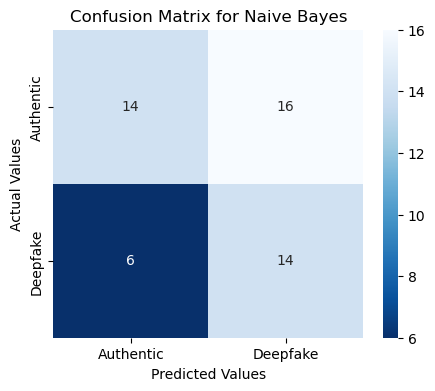

In [191]:
nb = GaussianNB()
nb_acc, nb_auc, nb_cm = evaluate_model(nb, "Naive Bayes")

K Nearest Neighbours

Training KNN...
Classification Report for KNN:
              precision    recall  f1-score   support

   Authentic       0.00      0.00      0.00        30
    Deepfake       0.40      1.00      0.57        20

    accuracy                           0.40        50
   macro avg       0.20      0.50      0.29        50
weighted avg       0.16      0.40      0.23        50


Accuracy for KNN: 0.4000
AUC for KNN: 0.5000



c:\Users\user\anaconda3\envs\is217_env\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\anaconda3\envs\is217_env\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\anaconda3\envs\is217_env\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


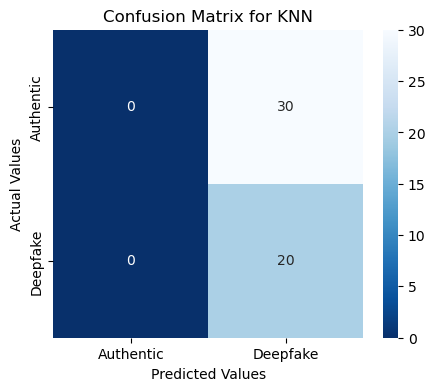

In [192]:
knn = KNeighborsClassifier(n_neighbors=3, algorithm='ball_tree', n_jobs=-1)
knn_acc, knn_auc, knn_cm = evaluate_model(knn, "KNN")

SVM

Training SVM...


c:\Users\user\anaconda3\envs\is217_env\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\anaconda3\envs\is217_env\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\anaconda3\envs\is217_env\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for SVM:
              precision    recall  f1-score   support

   Authentic       0.00      0.00      0.00        30
    Deepfake       0.40      1.00      0.57        20

    accuracy                           0.40        50
   macro avg       0.20      0.50      0.29        50
weighted avg       0.16      0.40      0.23        50


Accuracy for SVM: 0.4000
AUC for SVM: 0.4200



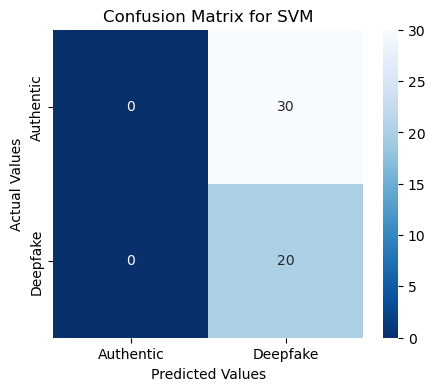

In [193]:
svm = SVC(probability=True)
svm_acc, svm_auc, svm_cm = evaluate_model(svm, "SVM")

Random Forrest

Training Random Forest...
Classification Report for Random Forest:
              precision    recall  f1-score   support

   Authentic       0.67      0.47      0.55        30
    Deepfake       0.45      0.65      0.53        20

    accuracy                           0.54        50
   macro avg       0.56      0.56      0.54        50
weighted avg       0.58      0.54      0.54        50


Accuracy for Random Forest: 0.5400
AUC for Random Forest: 0.5800



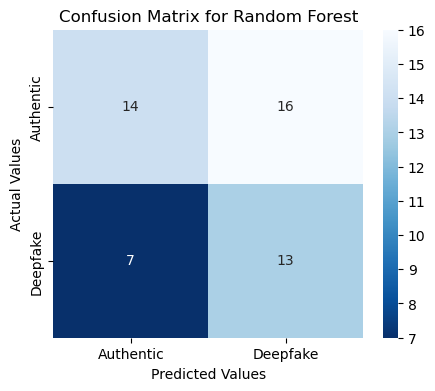

In [194]:
rf = RandomForestClassifier()
rf_acc, rf_auc, rf_cm = evaluate_model(rf, "Random Forest")

AdaBoost

Training AdaBoost...
Classification Report for AdaBoost:
              precision    recall  f1-score   support

   Authentic       0.60      0.50      0.55        30
    Deepfake       0.40      0.50      0.44        20

    accuracy                           0.50        50
   macro avg       0.50      0.50      0.49        50
weighted avg       0.52      0.50      0.51        50


Accuracy for AdaBoost: 0.5000
AUC for AdaBoost: 0.4800



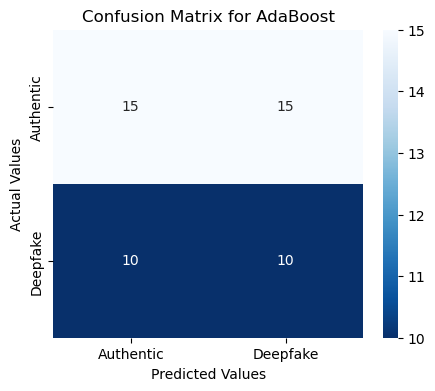

In [195]:
from sklearn.ensemble import AdaBoostClassifier

ada_model= AdaBoostClassifier(n_estimators=100, random_state=27)
ada_acc, ada_auc, ada_cm = evaluate_model(ada_model, "AdaBoost")

XGBoost

In [196]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


Training XGBoost...
Classification Report for XGBoost:
              precision    recall  f1-score   support

   Authentic       0.69      0.60      0.64        30
    Deepfake       0.50      0.60      0.55        20

    accuracy                           0.60        50
   macro avg       0.60      0.60      0.59        50
weighted avg       0.62      0.60      0.60        50


Accuracy for XGBoost: 0.6000
AUC for XGBoost: 0.5900



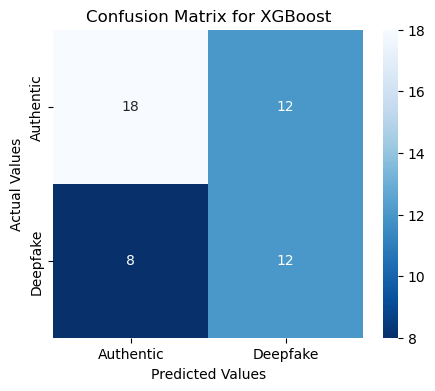

In [197]:
from xgboost import XGBClassifier
xgb =  XGBClassifier(n_estimators=100, random_state=27)
xgb_acc, xgb_auc, xgb_cm = evaluate_model(xgb, "XGBoost")

CatBoost

In [198]:
! pip install catboost

Training CatBoost...
Classification Report for CatBoost:
              precision    recall  f1-score   support

   Authentic       0.68      0.50      0.58        30
    Deepfake       0.46      0.65      0.54        20

    accuracy                           0.56        50
   macro avg       0.57      0.57      0.56        50
weighted avg       0.59      0.56      0.56        50


Accuracy for CatBoost: 0.5600
AUC for CatBoost: 0.5700



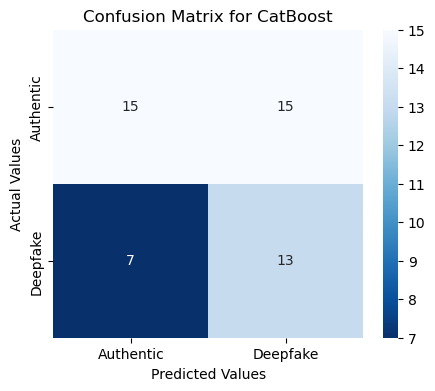

In [199]:
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(verbose=0) 
cat_acc, cat_auc, cat_cm = evaluate_model(cat_model, "CatBoost")

Summary of Evaluation


In [200]:
print("\nSummary of Results:")
models = ["Logistic Regression", "SVM", "KNN", "Decision Tree", "Random Forest", "Naive Bayes", "AdaBoost", "XGBoost", "CatBoost"]
accuracies = [log_reg_acc, svm_acc, knn_acc, dt_acc, rf_acc, nb_acc, ada_acc, xgb_acc, cat_acc]
auc_scores = [log_reg_auc, svm_auc, knn_auc, dt_auc, rf_auc, nb_auc, ada_auc, xgb_auc, cat_auc]
confusion_matrices = [log_reg_cm, svm_cm, knn_cm, dt_cm, rf_cm, nb_cm, ada_cm, xgb_cm, cat_cm]

results = {
    "Model": models,
    "Accuracy": accuracies,
    "AUC": auc_scores,
    "Confusion Matrix": confusion_matrices
}

# Create the DataFrame
results_df = pd.DataFrame(results)

# Print the DataFrame
print(results_df)


Summary of Results:
                 Model  Accuracy   AUC      Confusion Matrix
0  Logistic Regression      0.50  0.56    [[9, 21], [4, 16]]
1                  SVM      0.40  0.42    [[0, 30], [0, 20]]
2                  KNN      0.40  0.50    [[0, 30], [0, 20]]
3        Decision Tree      0.48  0.47   [[16, 14], [12, 8]]
4        Random Forest      0.54  0.58   [[14, 16], [7, 13]]
5          Naive Bayes      0.56  0.55   [[14, 16], [6, 14]]
6             AdaBoost      0.50  0.48  [[15, 15], [10, 10]]
7              XGBoost      0.60  0.59   [[18, 12], [8, 12]]
8             CatBoost      0.56  0.57   [[15, 15], [7, 13]]


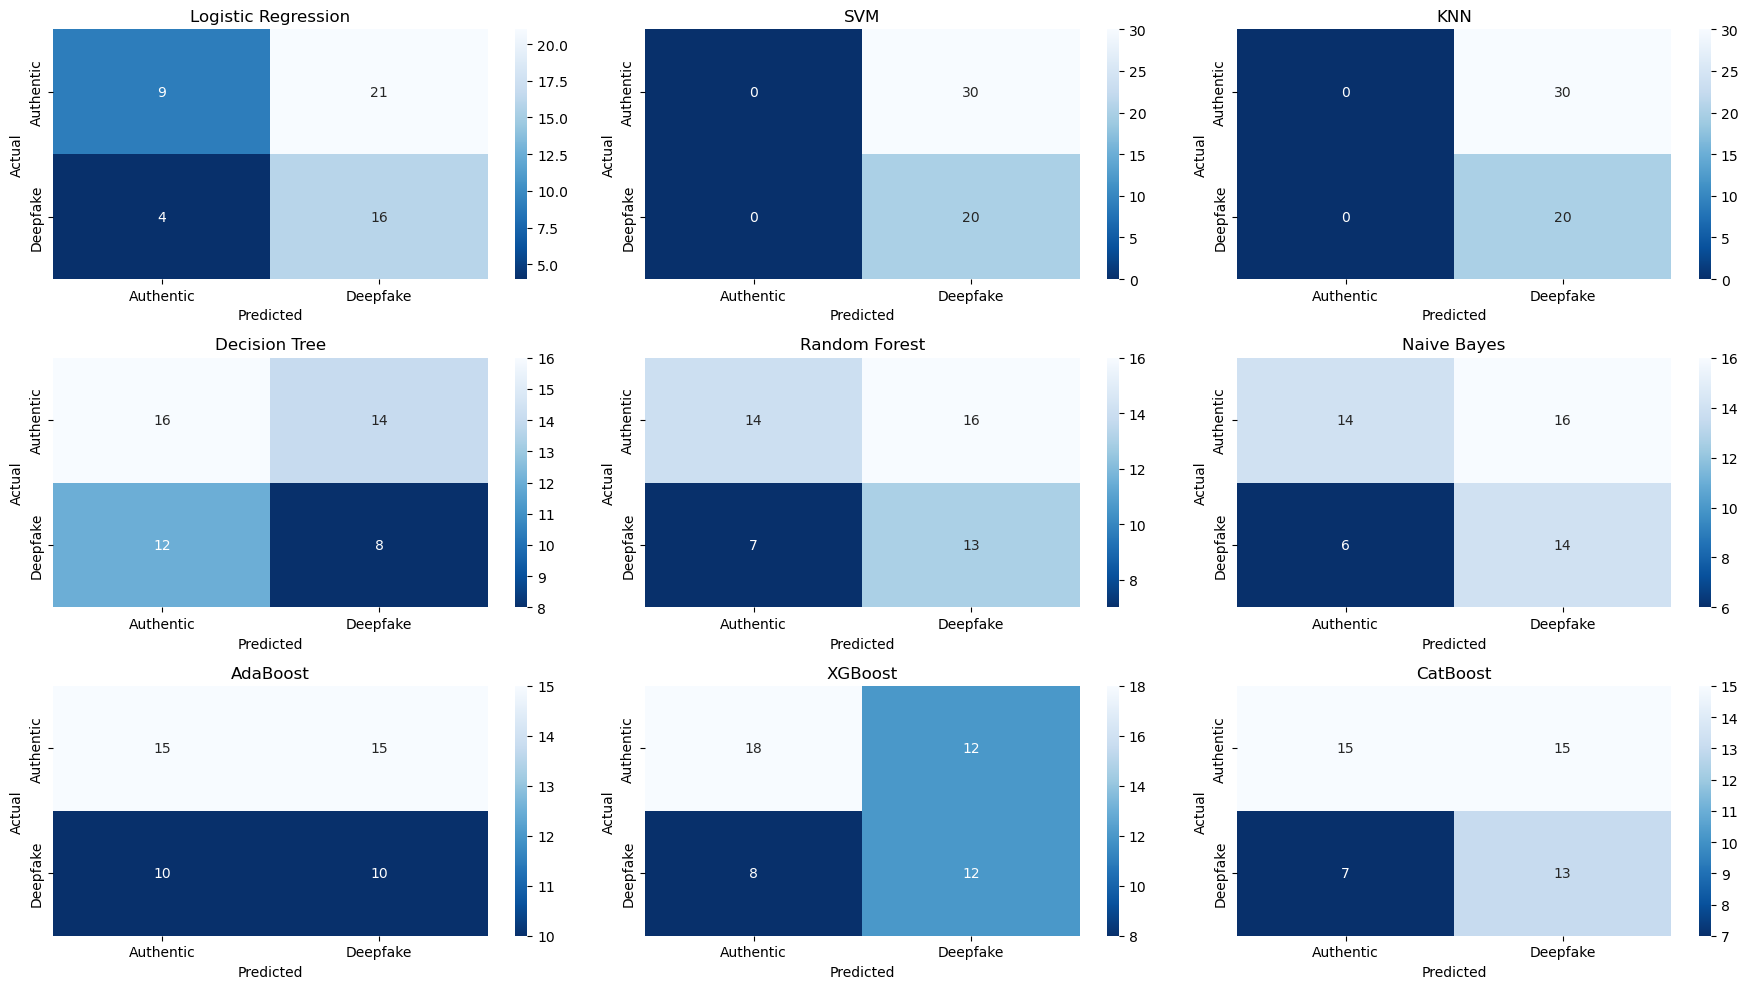

In [201]:
# List of models and their confusion matrices
models = ["Logistic Regression", "SVM", "KNN", "Decision Tree", "Random Forest", "Naive Bayes", "AdaBoost", "XGBoost", "CatBoost"]
confusion_matrices = [log_reg_cm, svm_cm, knn_cm, dt_cm, rf_cm, nb_cm, ada_cm, xgb_cm, cat_cm]

# Set up the plot
plt.figure(figsize=(18, 10))

target_names = ["Authentic", "Deepfake"]
    
for i, (model, cm) in enumerate(zip(models, confusion_matrices)):
    plt.subplot(3, 3, i + 1)  
    sns.heatmap(cm, annot=True, cmap='Blues_r', fmt='g', xticklabels=target_names, yticklabels=target_names)
    plt.title(model)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

plt.tight_layout()
plt.show()